In [3]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# from svm_base import SelfAttn
import math
import copy
import sys
from nxt_token_solver import W_svm_solver_cvxpy, R_solver, Tarjan

from utils import * 
from data_utils import * 
from train_utils import train_W, train_Wfin
from visualizer import show_corr, show_norm_diff, show_proj_corr, show_attn_probs, show_attn_probs_neg

# sys.path.insert(1, './..')
from base_nonlinear import MLayerAttn
# score: Random + normalize 
# corr + sofmtax + norm 

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # Always use the same algorithm to calculate the convolution
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
set_seed(1)


In [4]:
"""
Z = \mathbb{S}(XQK^TX^T)XV
h(X) = \langle {Zv, \mathbb{S}\bar{W}z_1} \rangle = \mathbb{S}(Z\bar{W}z_1)Zv   
where z_1 is the first token of the prompt
"""
inspect = False
# Useless for now
loop = False

# Numerical settings
use_double= True

# Optimization options

random_token = True

batch = True

loss_type = 'nll' # ['ce', 'nll', 'corr', 'lsq2', 'mse']
token_choice = 'random' # ['equi-corr', 'ortho', 'random']

# Data parameters
separa = False # Whether the last token can map to different labels
use_scc = True

"""
cls_choice: corresponds to the classifier assumption
check_acyc: corresponds to the acyclic assumption
check_label: corresponds to the realizable label assumption
rep_label: allowing different tokens with the same label
rep_seq: set X to be rank-1 sequence
same_last_token: manually set the last token to be the same
"""
rep_label = False # Whether to allow repeated labels in the sequence
rep_seq = False
check_label = True
cls_choice = 'iden'
check_asyc = False
same_last_token = False

toy_case = False
batch_toy = False 
custom_initialize = False # For local convergence purpose

# Model parameters
nlayer = 1 # number of layers

skip = False # add skip connection to every attention output 
layer_norm = False # add layer norm to every attention output
avg_norm = False
factorize_w = False # use W or (Q, K)

initialize_w = 'default' # 'default': random initialization, 'zero': initialize W as zero matrix, 'random': random initialization with varying variance
strong_default = False
initialize_wfin = 'zero'

reg_wfin = 0 # regularization for W_fin
# W_fin must be initialized as zero matrix

lr = 0.01
# output1= False
# cross_attn = True

epochs = 1
ITN = 1000

norm_grad = True

n = 3
T = 3
# K = 5
K = 5
# dlist = [2**i for i in range(1, 7)]
# dlist = [2, 4, 8, 32]
dlist = [8] # By setting d = T, the sequence contains all the tokens in the vocabulary without repetition

# dlist = [4, 8, 16]



# attn_probs = np.zeros((len(dlist), epochs, n, T))
# We are only interested in the final attention probs
# First T is T outputs, second T is T tokens 


corr_list = np.zeros((len(dlist), 2, epochs, ITN))
proj_corr_list = np.zeros((len(dlist), epochs, ITN))

perp_corr = np.zeros((len(dlist), epochs))
attn_probs = np.zeros((len(dlist), epochs, ITN))
assert nlayer == 1 
Wi_norm_list = np.zeros((nlayer, epochs, ITN))
Wdiff_norm_list = np.zeros((len(dlist), epochs, ITN))
Wfin_norm_list = np.zeros((len(dlist), epochs, ITN))
# num_glob1 = np.zeros((len(dlist)))
num_glob = np.zeros((len(dlist)))
# run_local = []
# unsol_cnt = 0
cnt_dist = np.zeros((len(dlist), 3))


In [5]:
# for di in range(len(dlist)):
cvg_thres = 1 - 1e-6
for di in range(len(dlist)):
    print("Current d: ", dlist[di])
    d = dlist[di]
    for ei in range(epochs):
        # if check_asyc == False:
        #     same_last_token = np.random.randint(2) # Generate the same last token for all the samples to ensure cyclic graph
        if ei % 50 == 0:
            print("Current epoch: ", ei)
        
        flag = False
        # while (not flag):
        print("Sample {}".format(ei))
        X, Vocab, C, dict_token, idx_token = next_data(
            n = n, T = T, K = K, d = d,
            rep_seq = rep_seq, token_choice= token_choice,
            same_last_token = same_last_token, 
            check_label = check_label, check_asyc = check_asyc
        )
        if toy_case:
            X, C, idx_token = manual_toy_case(X, Vocab, idx_token, vary_len = batch_toy)

        print("idx_token", idx_token)


        if custom_initialize:
            if ei == 0:
                const = torch.tensor(10)
            else:
                const = torch.randn(1) * 2
            alphas = [-1.5, 0, 1.5, 0.5, -0.5]
            # alphas = [-2, 2, 1, 0, -1]
            
            # alpha1 = [-4, 0, 4, 3, 2, 1,0,-1,-2,-3]
            # alpha2 = [-3, 1, 0, -1, 3,2,1,0,-1,-2]
            alphas = alphas
            init_w_toy = torch.zeros((d, d)).double()
            for i in range(len(alphas)):
                init_w_toy += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alphas[i]
            init_w_toy = const.double() * init_w_toy
            print("Margins should be 1, 1, 1, >1, >1")
            # print((Vocab[4] - Vocab[0]).reshape(1, -1) @ init_w_toy @ Vocab[0])
            for i in range(K - 1):
                print("{} - {} margin".format(i, i+1))
                print((Vocab[i] - Vocab[i + 1]).reshape(1, -1) @ init_w_toy @ Vocab[0].reshape( -1, 1))

        if toy_case and batch_toy:
            z = []
            for i in range(len(X)):
                zi = X[i][-1]
                z.append(zi)
            z = torch.stack(z)
            assert z.shape == (n, d)
        else:
            z = X[:, -1].unsqueeze(1) # [n, d]
        idx_z = []
        
        for i in range(n):
            idx_zi = search_key(dict_token, z[i].squeeze())
            idx_z.append(idx_zi)
        idx_z = torch.tensor(idx_z)
        C_alpha = C
        # C_alpha = C[np.arange(n),idx_z]
        print("C_alpha", C_alpha)

        scc_klst = []
        if toy_case:
            assert len(set(idx_z)) == len(idx_z), "for toy case we only assuem the same last token"
            for k in range(K):
                if idx_z[0] == k:
                    tarjan_solver = Tarjan(K)
                    tarjan_solver.initialize(idx_token, C_alpha)
                    tarjan_solver.run()
                    scc_lst = tarjan_solver.get_scc()
                    scc_klst.append(scc_lst)
                else:
                    scc_klst.append([])
        else:
            for k in range(K):
                tarjan_solver = Tarjan(K)
                mask = idx_token[:, -1] == k
                cnt = torch.sum(mask).item()
                if cnt == 0:
                    scc_klst.append([])
                    continue
                tarjan_solver.initialize(idx_token[mask], C_alpha[mask])
                tarjan_solver.run()
                scc_lst = tarjan_solver.get_scc()
                scc_klst.append(scc_lst)
        print("SCC ", scc_klst)
        model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                        identity_W=False, identity_V = True, 
                        factorize_W = factorize_w, init = initialize_w,
                        skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                ).double()
        # print(model.qklist[0].weight)
        # Copy one model to Wfin
        if strong_default:
            model_fin = copy.deepcopy(model)
        # print("Covariance of the weight matrix on initialization: ", torch.cov(model.qklist[0].weight))
        if not custom_initialize:
            print("Using {} initialization".format(initialize_w))
            print("Variance of the weight matrix on initialization: ", torch.var(model.qklist[0].weight))

            
        # Parameter Initialization 
        if factorize_w:
            parameter_list = [model.query1.weight, model.query2.weight, model.key1.weight, model.key2.weight]
        else:
            parameter_list = [m.weight for m in model.qklist]
        
        if layer_norm and not avg_norm:
            parameter_list += [model.ln.weight, model.ln.bias]
        if custom_initialize:
            print("Initialize w manually")
            model.qklist[0].weight.data = init_w_toy
            print("Norm of w on initialization: ", init_w_toy.norm())
        optimizer = torch.optim.SGD(parameter_list, lr=lr, )
        Wi_list = np.zeros((nlayer, ITN, d, d))
        Wfini_list = np.zeros((nlayer, ITN, d, d))
        sol_cvx_list = np.zeros((nlayer, d, d))

        if token_choice == 'equi-corr':
            adj_mat = np.zeros((K -1, K - 1, K -1)) # #of distinct last tokens, |ID|, |ID|
        else:
            adj_mat = np.zeros((K , K , K )) # #of distinct last tokens, |ID|, |ID|
        
        for i in range(len(idx_token)):
            for j in range(len(idx_token[i])):
                if C_alpha[i] == idx_token[i][j]:
                    continue
                adj_mat[idx_token[i][-1], C_alpha[i], idx_token[i][j]] = 1
        print("Solving the SVM problem using mm constriants")
        w_dir = W_svm_solver_cvxpy(Vocab, n, d, idx_z, idx_token, C, onetoken = False, wfin = False, adj_mat = adj_mat,  W_grad = Wi_list[0, -1], scc_lst = scc_klst) 
        sol_cvx_list[0] =  normalize_sol(w_dir)

        if not batch_toy:
            red_X, red_idx_token, cyc_X, cyc_idx_token = generate_reduced_ds(X, T, idx_token, C_alpha, scc_klst)
            Sfin = cal_Sfin(K, idx_token, red_idx_token, C_alpha, scc_klst, Vocab)

        model = train_W(
            model, X, idx_token, z, token_choice, cls_choice, Vocab, C_alpha, nlayer,
            n, K, di, ei, ITN, toy_case, batch_toy, scc_klst,
            loss_type, optimizer, norm_grad, parameter_list, 
            Wi_list = Wi_list, attn_probs = attn_probs, Wi_norm_list = Wi_norm_list, 
            # corr_list = corr_list, sol_cvx_list = sol_cvx_list,
            )      



        # Calculating W_fin 
        # if np.isclose(w_dir, np.zeros((d, d))).all():
        #     corr_list[di, 0, ei, :] = np.nan
        if not batch_toy:
            # red_X, red_idx_token, cyc_X, cyc_idx_token = generate_reduced_ds(X, T, idx_token, C_alpha, scc_klst)
            # Sfin = cal_Sfin(K, idx_token, red_idx_token, C_alpha, scc_klst, Vocab)
            # red_z = []
            # for i in range(len(red_X)):
            #     red_z.append(red_X[i][:, -1])
            # red_z = torch.cat(red_z, dim = 0).unsqueeze(1)
            if not strong_default:
                model_fin = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                                identity_W=False, identity_V = True, 
                                factorize_W = factorize_w, init = initialize_wfin,
                                skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                        ).double()
            # print(model_fin.qklist[0].weight)
            # Parameter Initialization 
            parameter_list = [m.weight for m in model_fin.qklist]

            optimizer = torch.optim.SGD(parameter_list, lr=lr)
            empty_X = True
            for i in range(len(red_X)):
                if len(red_X[i]) != 0:
                    empty_X = False
                    break
            if not empty_X:
                train_Wfin(model_fin, w_dir, red_X, red_idx_token, z, token_choice, cls_choice, Vocab, C_alpha, nlayer, 
                        n, K, di, ei, ITN,
                        loss_type, optimizer, norm_grad, parameter_list, 
                        Wfini_list, perp_corr = perp_corr, local = False,
                        # corr_list = corr_list, w_dir = w_dir
                )
            # Optimizing R 
            if use_scc:
                R = R_solver(Wi_list, Wfini_list, w_dir)

        
            
            for it in range(ITN):
                prj_w = project_subspace(Sfin, Wi_list[0, it])
                prj_w_cp = Wi_list[0, it] - prj_w
                proj_corr_list[di, ei, it] = cal_corr(w_dir, prj_w_cp)
                Wdiff_norm_list[di, ei, it] = np.linalg.norm(prj_w - Wfini_list[0, it])
                Wfin_norm_list[di, ei, it] = np.linalg.norm(Wfini_list[0, it])
                Wi_list[0, it] /= np.linalg.norm(Wi_list[0, it])
                # corr_list[di, 0, ei, it] = Wi_list[0, it].reshape(-1).dot(sol_cvx_list[0, 0].reshape(-1))
                if not separa:
                    # if corr_list[di, 0, ei, it] == 0:
                    corr_list[di, 0, ei, it] = Wi_list[0, it].reshape(-1).dot(sol_cvx_list[di].reshape(-1))
                    corr_list[di, 1, ei, it] = Wi_list[0, it].reshape(-1).dot(normalize_sol(Wfini_list[0, -1] + R * w_dir).reshape(-1))
                    
                    
                # if it % 100 == 0:
                #     print("Iters {}, Correlation between Wmm and W: {:.4f}".format(it, cal_corr(Wi_list[0, it], w_dir)))
                if it == ITN - 1 and corr_list[di, :, ei, it].max() < 0.95 and np.linalg.norm(w_dir) > 0:
                    print("Correlation is too low")
                    print(corr_list[di, :, ei, it].max())
                    print("X: ", X)
                    raise Exception("Correlation is too low")
            print("Correlation of W and Wsvm", corr_list[di, 0, ei, -1])
            # print("SCC\n", scc_klst)
            print("Norm of difference: ", Wdiff_norm_list[di, ei, -1])
            print("Norm of sfin complement of Wfin", np.linalg.norm(Wfini_list[0, -1] - project_subspace(Sfin, Wfini_list[0, -1])))
        # Inspection on the attention probs
        if inspect:
            x = []

            # # 1 = 3 > 0 
            # idx_token_0 = torch.tensor([1,  3,0])
            # x0  = torch.zeros(1, len(idx_token_0), d).double()
            # x0[0] = Vocab[idx_token_0]
            # x.append(x0)

            # original_W = model.qklist[0].weight.data.clone()

            # for xi in x:
            #     # print(xi)

            #     out = model(xi, xi[0,-1].unsqueeze(0))
            #     print(model.attn[0])
            #     mask = torch.nn.functional.one_hot(idx_token_0.unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
            #     hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1)
            #     print(hat_y.squeeze())
            # x = []
            
            idx_token_0 = torch.tensor([1,3,0])
            # idx_token_0 = torch.tensor([2,0])
            x0 = torch.zeros(1, len(idx_token_0), d).double()
            x0[0] = Vocab[idx_token_0]
            x.append(x0)

            original_W = model.qklist[0].weight.data.clone()

            for xi in x:
                # print(xi)

                out = model(xi, xi[0,-1].unsqueeze(0))
                mask = torch.nn.functional.one_hot(idx_token_0.unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
                hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1)
                print("Probability")
                print(hat_y.squeeze())

                model.qklist[0].weight.data = torch.from_numpy(w_dir / np.linalg.norm(w_dir))
                out = model(xi, xi[0,-1].unsqueeze(0))
                mask = torch.nn.functional.one_hot(idx_token_0.unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
                hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1)
                print("Probability by svm sols")
                print(hat_y.squeeze())

                model.qklist[0].weight.data = torch.from_numpy(w_dir / np.linalg.norm(w_dir)) * torch.norm(original_W)
                out = model(xi, xi[0,-1].unsqueeze(0))
                mask = torch.nn.functional.one_hot(idx_token_0.unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
                hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1)
                print("Probability by svm sols with same norm as gd")
                print(hat_y.squeeze())
                model.qklist[0].weight.data = original_W
    num_glob[di] = num_glob[di] / (epochs)

# print("Number of unsolved sols:", unsol_cnt)

Current d:  8
Current epoch:  0
Sample 0
idx_token tensor([[2, 3, 1],
        [2, 4, 0],
        [2, 3, 1]])
C_alpha tensor([2, 2, 1])
SCC  [[0, 1, 3, 4, 2], [0, 2, 2, 1, 3], [], [], []]
Using default initialization
Variance of the weight matrix on initialization:  tensor(0.0440, dtype=torch.float64, grad_fn=<VarBackward0>)
Solving the SVM problem using mm constriants
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 1.1322
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 500, Loss: 0.4837
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Training W_fin
tensor([[2, 1]])
tensor(2)
tensor([[2, 1]])
tensor(1)
Training W_fin Current iteration: 0, Loss: 0.4621
Norm of grad:  tensor(0., dtype=torch.float64)
Norm of grad:  tensor(0., dtype=torch.float64)
Training W_fin Current iteration: 500, Loss: 0.4621
Norm of grad:  tensor(0., dtype=torch.float64)
Norm of grad:  tensor(0., dtype=torch.flo

In [ ]:
x = []
# 1 = 3 > 0 
idx_token_0 = torch.tensor([1, 3,3,3,0])
x0  = torch.zeros(1, len(idx_token_0), d).double()
x0[0] = Vocab[idx_token_0]
x.append(x0)


for xi in x:
    # print(xi)

    out = model(xi, xi[0,-1].unsqueeze(0))
    # print(model.attn[0])
    mask = torch.nn.functional.one_hot(idx_token_0.unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
    hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1)
    print(hat_y.squeeze())
x = []

idx_token_0 = torch.tensor([2,0])
x0  = torch.zeros(1, len(idx_token_0), d).double()
x0[0] = Vocab[idx_token_0]
x.append(x0)

# original_W = model.qklist[0].weight.data.clone()

for xi in x:
    # print(xi)

    out = model(xi, xi[0,-1].unsqueeze(0))
    mask = torch.nn.functional.one_hot(idx_token_0.unsqueeze(0), num_classes=K).float().permute(0, 2, 1).double()
    hat_y = (mask @ model.attn[0].permute(0, 2, 1)).squeeze(-1)
    print(hat_y.squeeze())

In [ ]:
model(X, X[:, -1].unsqueeze(1))
print(model.attn[0].detach().numpy())

In [ ]:
w = w_dir
if torch.is_tensor(w):
    model.qklist[0].weight.data = w.double()
else:
    model.qklist[0].weight.data = torch.from_numpy(w).double()
model(X, X[:, -1].unsqueeze(1))
print(model.attn[0].detach().numpy())

In [ ]:
print("Correlation")
for ii in range(corr_list.shape[1]):
    print(corr_list[0, ii, :, -1])
print(proj_corr_list[0, :, -1])

In [ ]:
# For detecting local convergence 
# alpha1 = [-1.5, 0, 1.5, 0.5, -0.5]
# alpha2 = [-2, 2, 1, 0, -1]
# init_w_local1 = torch.zeros((d, d)).double()
# init_w_local2 = torch.zeros((d, d)).double()
# for i in range(len(alpha1)):
#     init_w_local1 += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alpha1[i]
# for i in range(len(alpha2)):
#     init_w_local2 += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alpha2[i]
# print(cal_corr(init_w_local1, model.qklist[0].weight.detach().numpy()))
# print(cal_corr(init_w_local2, model.qklist[0].weight.detach().numpy()))

# alpha1 = [-4, 0,4,3,2,1,0,-1,-2,-3]
# alpha2 = [-3, 1,0,-1,3,2,1,0,-1,-2]
# init_w_local1 = torch.zeros((d, d)).double()
# init_w_local2 = torch.zeros((d, d)).double()
# for i in range(len(alpha1)):
#     init_w_local1 += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alpha1[i]
# for i in range(len(alpha2)):
#     init_w_local2 += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alpha2[i]
# print(cal_corr(init_w_local1, model.qklist[0].weight.detach().numpy()))
# print(cal_corr(init_w_local2, model.qklist[0].weight.detach().numpy()))

# alpha_opt = [-4.5, 4.5, 3.5, 2.5, 1.5, 0.5, -0.5, -1.5, -2.5, -3.5]
# init_w_opt = torch.zeros((d, d)).double()
# for i in range(len(alpha_opt)):
#     init_w_opt += Vocab[i].reshape(-1,1) @ Vocab[0].reshape(1,-1) * alpha_opt[i]
# cal_corr(init_w_opt, w)
# w = init_w_local1
# for i in range(K - 1):
#     print("{} - {} margin".format(i, i+1))
#     print((Vocab[i] - Vocab[i + 1]).reshape(1, -1) @ w @ Vocab[0].reshape( -1, 1))

In [ ]:
def check_constraint(Vocab, W, scc_lst, adj_mat):
    for k in range(K):
        if scc_lst[k] == []:
            continue
        for i in range(K):
            for j in range(K):
                if i == j:
                    continue
                if scc_lst[k][i] == scc_lst[k][j]:
                    print("{} {} zero constraint".format(i + 1, j + 1))
                    print((Vocab[i] - Vocab[j]).reshape(1, -1) @ W @ Vocab[k].reshape(-1, 1))
                elif adj_mat[k, i, j] == 1:
                    print("e{} - e{} >= 1 constraint".format(i + 1, j + 1))
                    print((Vocab[i] - Vocab[j]).reshape(1, -1) @ W @ Vocab[k].reshape(-1, 1))
check_constraint(Vocab, w_dir, scc_klst, adj_mat)
print("Distance between e2 and e4 using w_gd: ")
print((Vocab[1] - Vocab[3]).reshape(1, -1) @ original_W @ Vocab[0].reshape(-1, 1))

print("Distance between e2 and e4 using w_dir: ")
print((Vocab[1] - Vocab[3]).reshape(1, -1) @ w_dir @ Vocab[0].reshape(-1, 1))

In [ ]:
w = model.qklist[0].weight.data.clone()
for i in range(K):
    # print("embedding {}".format(i + 1))
    # print(Vocab[i].reshape(1, -1) @ normalize_sol(w) @ Vocab[0].reshape( -1, 1))
    print("Margin with e_{}: ".format(i))
    print((Vocab[i] - Vocab[0]).reshape(1, -1) @ normalize_sol(w) @ Vocab[0].reshape( -1, 1))

w = w_dir
for i in range(K):
    # print("embedding {}".format(i + 1))
    # print(Vocab[i].reshape(1, -1) @ normalize_sol(w) @ Vocab[0].reshape( -1, 1))
    print("Margin with e_1: ")
    print((Vocab[i] - Vocab[0]).reshape(1, -1) @ w @ Vocab[0].reshape( -1, 1))

--------Section 1 correlation between Wgd and Wsvm sols--------
Only shows Wmm


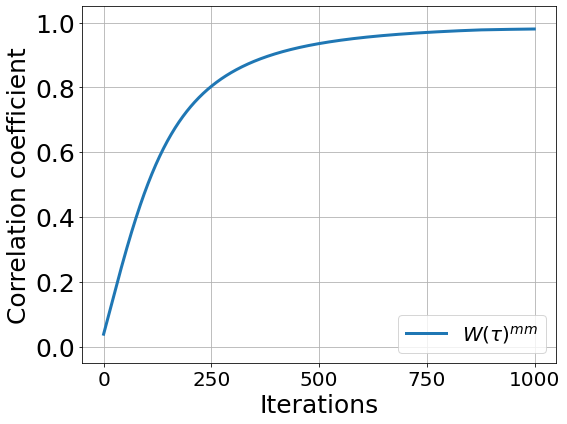

--------Section 2 norm difference between Wgd and Wsvm sols--------


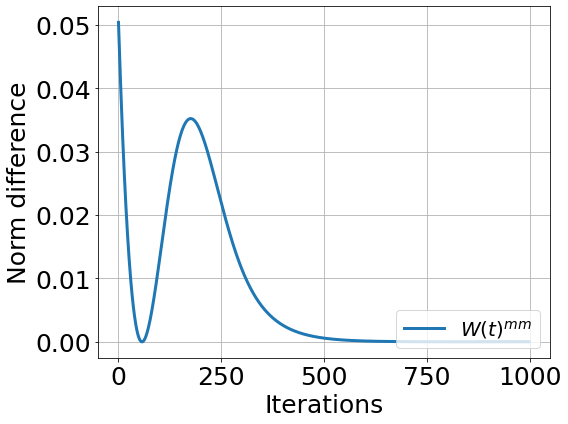

--------Section 3 projected correlation between proj_Sfin(Wgd) and Wfin sols--------


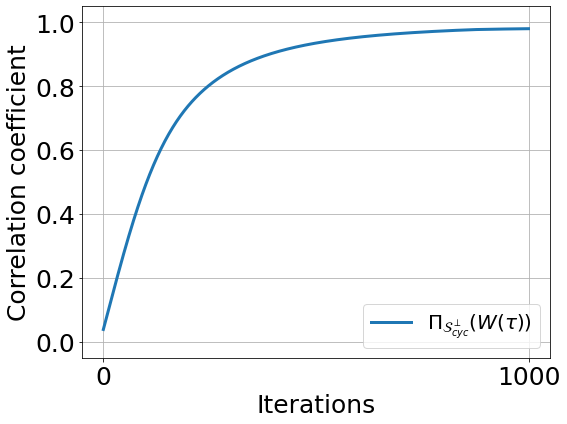

--------Section 4 attn probs--------


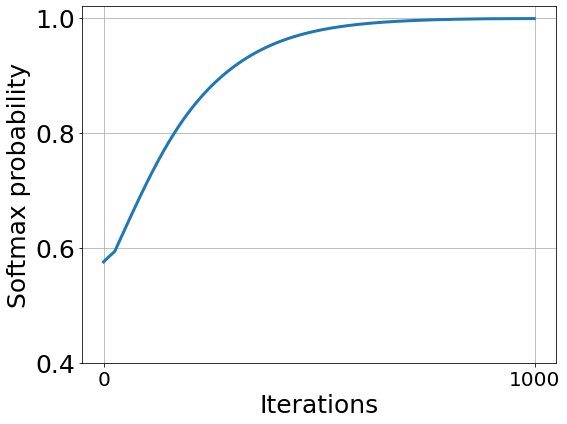

--------Section 5 attn probs (-log)--------


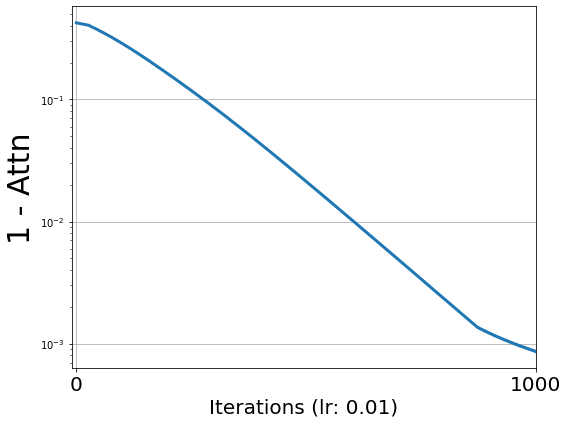

In [6]:
print("-"*8 + "Section 1 correlation between Wgd and Wsvm sols"+"-"*8)
labels = [
    # r'$W(t)^{onetoken}$', 
    r'$W(\tau)^{mm}$', 
    r'$W(\tau)$', 
]
show_corr(ITN, dlist, corr_list, wmm = True, labels = labels)
# show_local_corr(ITN, dlist, corr_list, local_corr_list, wmm = False)

print("-"*8 + "Section 2 norm difference between Wgd and Wsvm sols"+"-"*8)
labels = [
    # r'$W(t)^{onetoken}$', 
    r'$W(t)^{mm}$', 
    r'$W(t)$', 
]
show_norm_diff(ITN, dlist, Wdiff_norm_list, labels = labels)

print("-"*8 + "Section 3 projected correlation between proj_Sfin(Wgd) and Wfin sols"+"-"*8)
labels = [
    # r'$W(t)^{onetoken}$', 
    r'$\Pi_{\mathcal{S}^{\perp}_{cyc}}(W(\tau))}$', 
]
show_proj_corr(ITN, dlist, proj_corr_list, labels = labels)

print("-"*8 + "Section 4 attn probs"+"-"*8)
show_attn_probs(ITN, attn_probs, 0, lr)

print("-"*8 + "Section 5 attn probs (-log)"+"-"*8)
show_attn_probs_neg(ITN, attn_probs, 0, lr)

In [ ]:
dir = "tmp_logs/"
with open('corr_cyc.npy', 'wb') as f:
    np.save(f, corr_list)
with open('proj_corr_cyc.npy', 'wb') as f:
    np.save(f, proj_corr_list)
with open('sfx_cyc.npy', 'wb') as f:
    np.save(f, attn_probs)

with open('wfin.npy', 'wb') as f:
    np.save(f, Wfin_norm_list)

with open('norm_diff.npy', 'wb') as f:
    np.save(f, Wdiff_norm_list)

In [ ]:
# # You can also load the data from the saved file
# cdir = 'logs/global_exp'

# with open(cdir +'norm_diff.npy', 'rb') as f:
#     Wdiff_norm_list = np.load(f)